In [45]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import commonfunctions as cf
import cv2
import numpy as np
import matplotlib.pyplot as plt


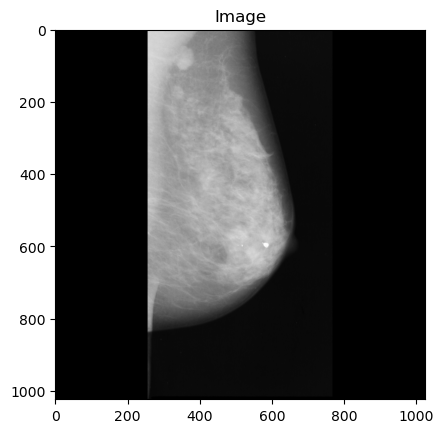

In [47]:
import os
from skimage import io
image_name='mdb270.pgm'
img_path = f"all-mias/{image_name}"

img = io.imread(img_path)
show_images([img], ['Image'])


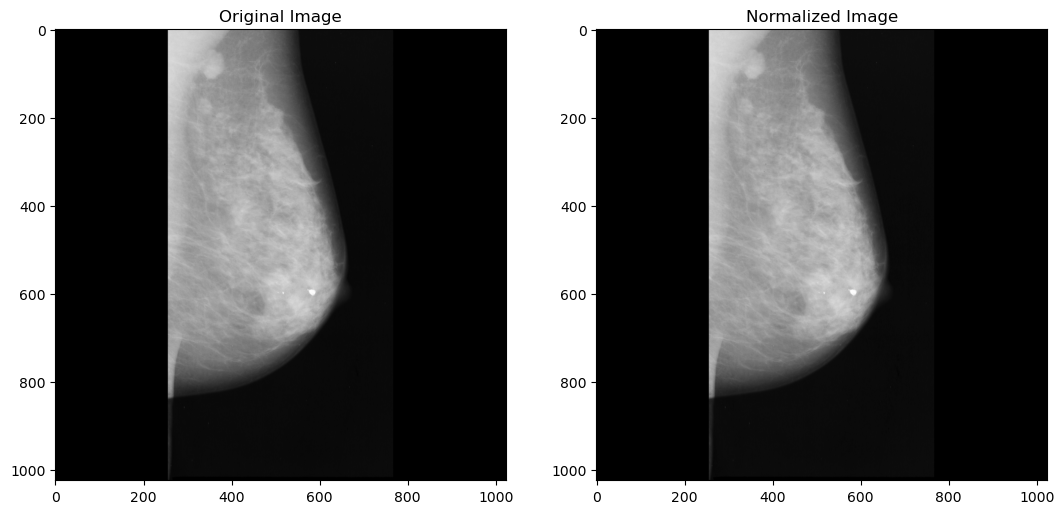

In [48]:
# Normalize to 0–255
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
img_uint8 = np.uint8(img_norm)
show_images([img, img_uint8], ['Original Image', 'Normalized Image'])

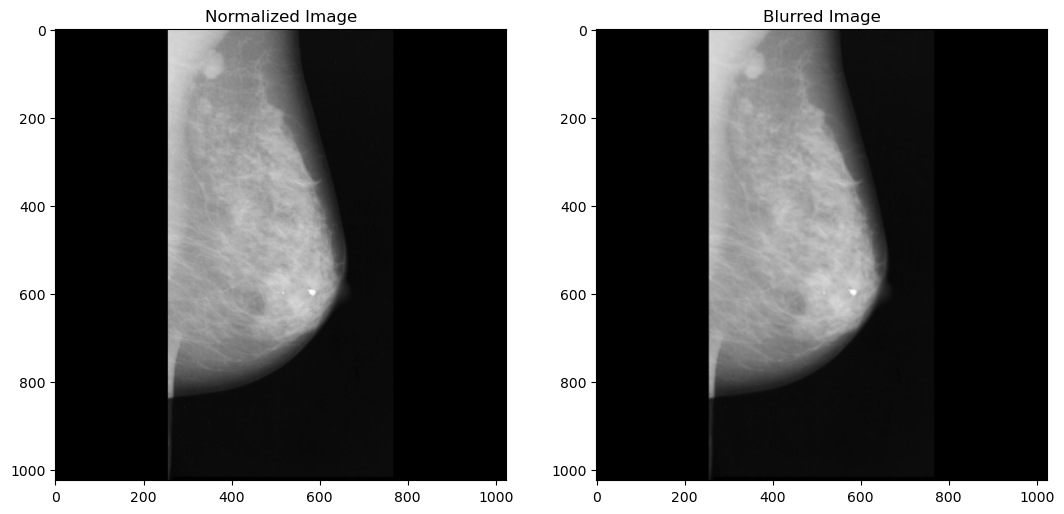

In [49]:

img_blur = cv2.GaussianBlur(img_uint8, (5, 5), 0)
show_images([img_uint8, img_blur], ['Normalized Image', 'Blurred Image'])

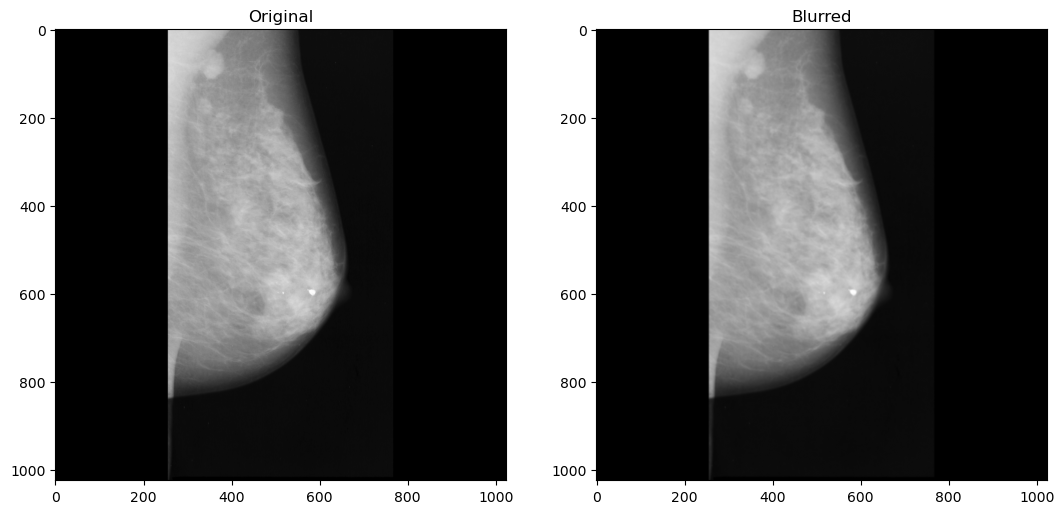

In [50]:
show_images([img_uint8, img_blur], ['Original', 'Blurred'])

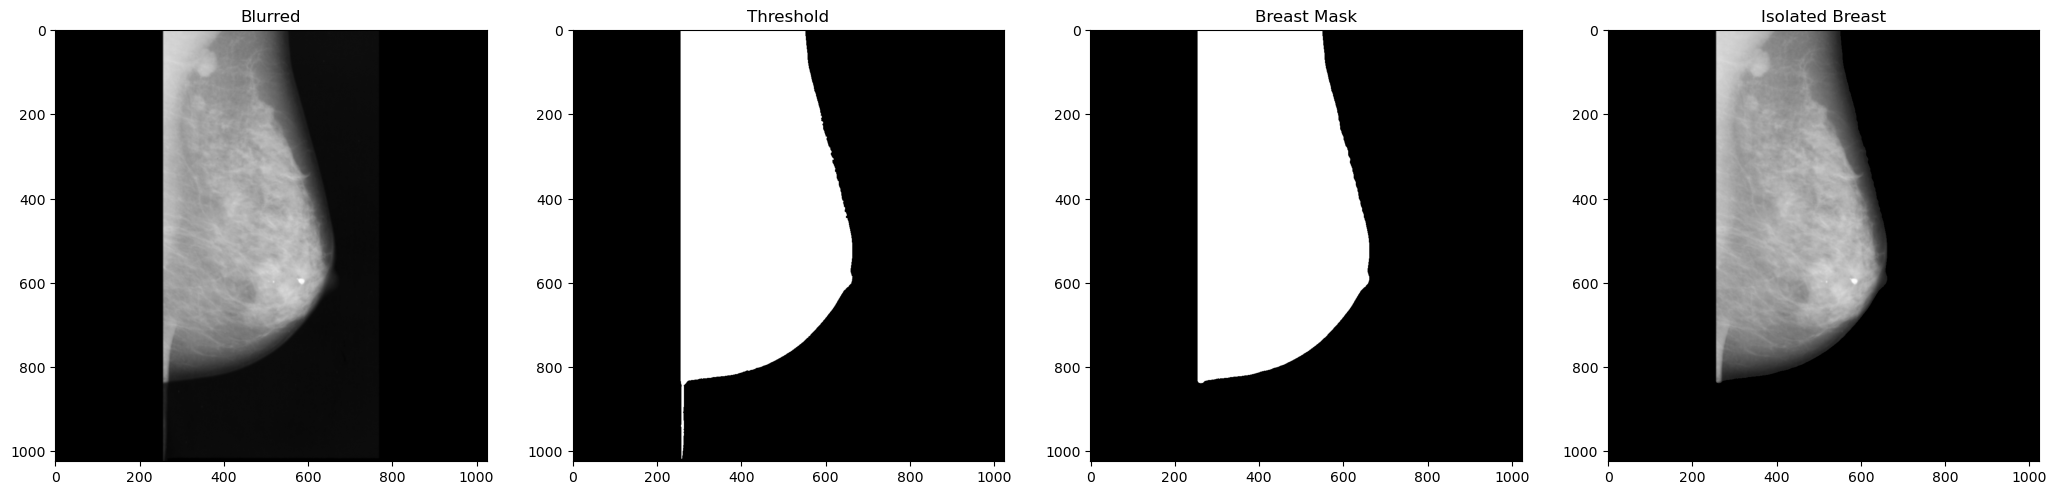

In [51]:
# STEP 1: First isolate the breast region before equalization
# This prevents background grey levels from affecting the breast tissue equalization

# Threshold to separate breast from background
_, thresh_breast = cv2.threshold(img_blur, 30, 255, cv2.THRESH_BINARY)

# Use connected components to get the largest region (breast)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh_breast, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

# Create breast mask
breast_mask = np.zeros_like(thresh_breast)
breast_mask[labels == largest_label] = 255

# Smooth the mask edges
kernel_mask = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
breast_mask = cv2.morphologyEx(breast_mask, cv2.MORPH_CLOSE, kernel_mask)
breast_mask = cv2.morphologyEx(breast_mask, cv2.MORPH_OPEN, kernel_mask)

# Apply mask to get only breast region
breast_region = cv2.bitwise_and(img_blur, img_blur, mask=breast_mask)

show_images([img_blur, thresh_breast, breast_mask, breast_region], 
            ['Blurred', 'Threshold', 'Breast Mask', 'Isolated Breast'])

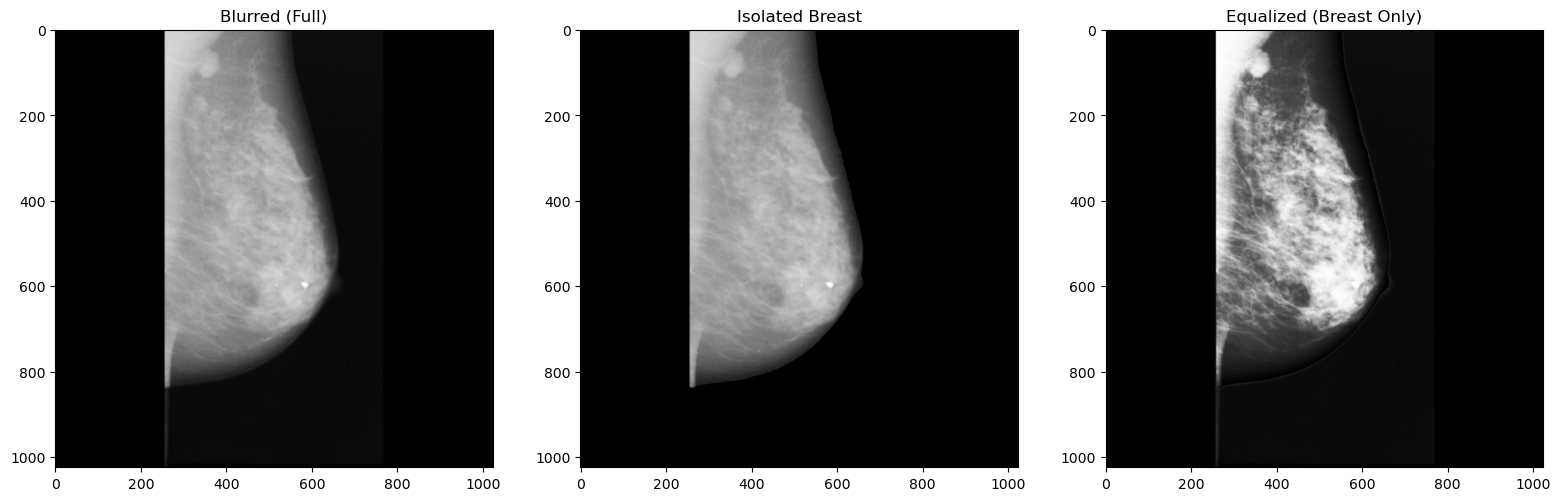

In [52]:
# STEP 2: Apply histogram equalization ONLY to the breast region
# This ensures background grey levels don't affect the breast tissue contrast

# Extract only breast pixels (exclude background)
breast_only = breast_region[breast_mask > 0]

if len(breast_only) > 0:
    # Create histogram from breast pixels ONLY (ignoring background)
    hist, bins = np.histogram(breast_only.flatten(), 256, [0, 256])
    
    # Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = (cdf * 255) / cdf[-1]  # Normalize to 0-255
    
    # Create the final image: start with original blurred image
    img_eq = img_blur.copy()
    
    # Apply equalization mapping ONLY to breast region pixels
    img_eq[breast_mask > 0] = cdf_normalized[breast_region[breast_mask > 0]]
else:
    img_eq = img_blur.copy()

show_images([img_blur, breast_region, img_eq], 
            ['Blurred (Full)', 'Isolated Breast', 'Equalized (Breast Only)'])

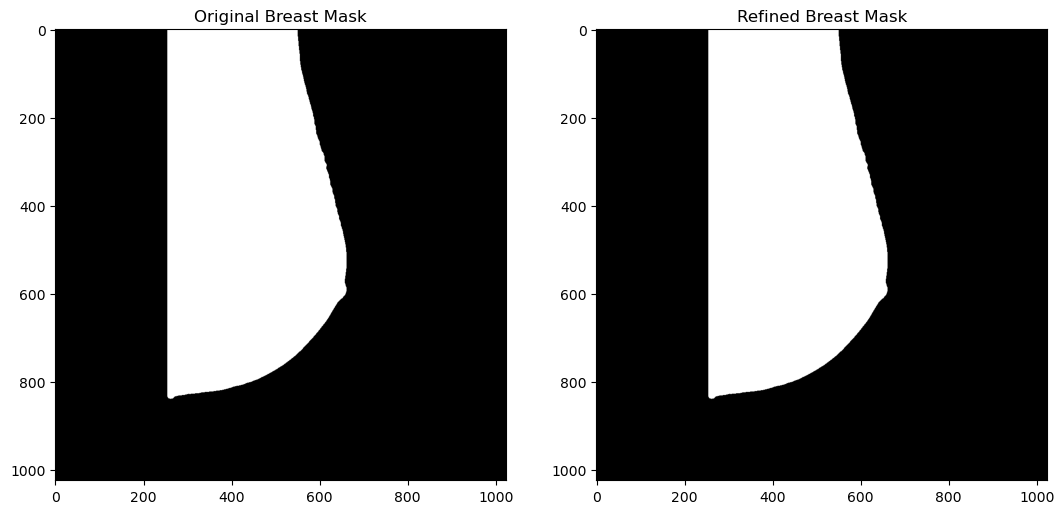

In [53]:
# Now use the breast mask we already created
# Refine it slightly if needed
clean_mask = breast_mask.copy()

# Optional: Further refine the breast mask if needed
# (The mask from step 1 should already be good, but we can clean it up)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)

show_images([breast_mask, clean_mask], ['Original Breast Mask', 'Refined Breast Mask'])

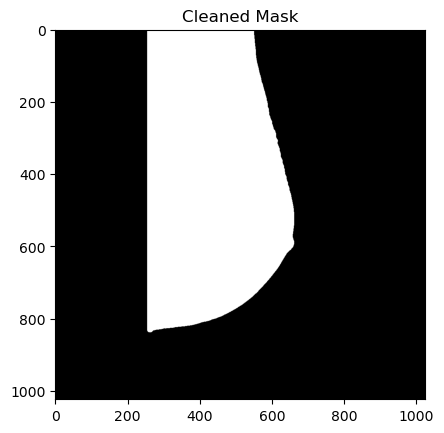

In [54]:
show_images([clean_mask], ['Cleaned Mask'])

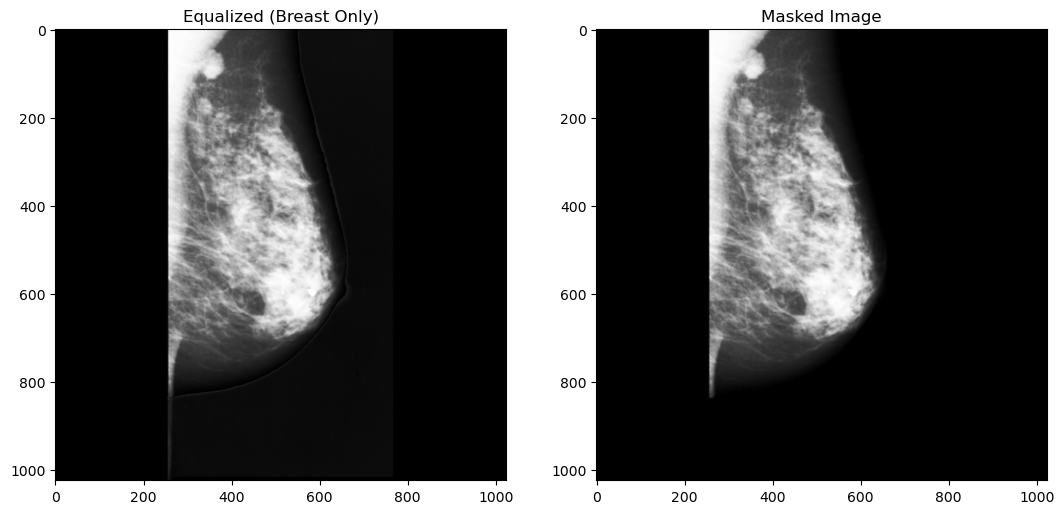

In [55]:
# Apply the breast mask to the equalized image
# Since we already equalized only the breast region, this should be the same
masked_img = cv2.bitwise_and(img_eq, img_eq, mask=clean_mask)
show_images([img_eq, masked_img], ['Equalized (Breast Only)', 'Masked Image'])

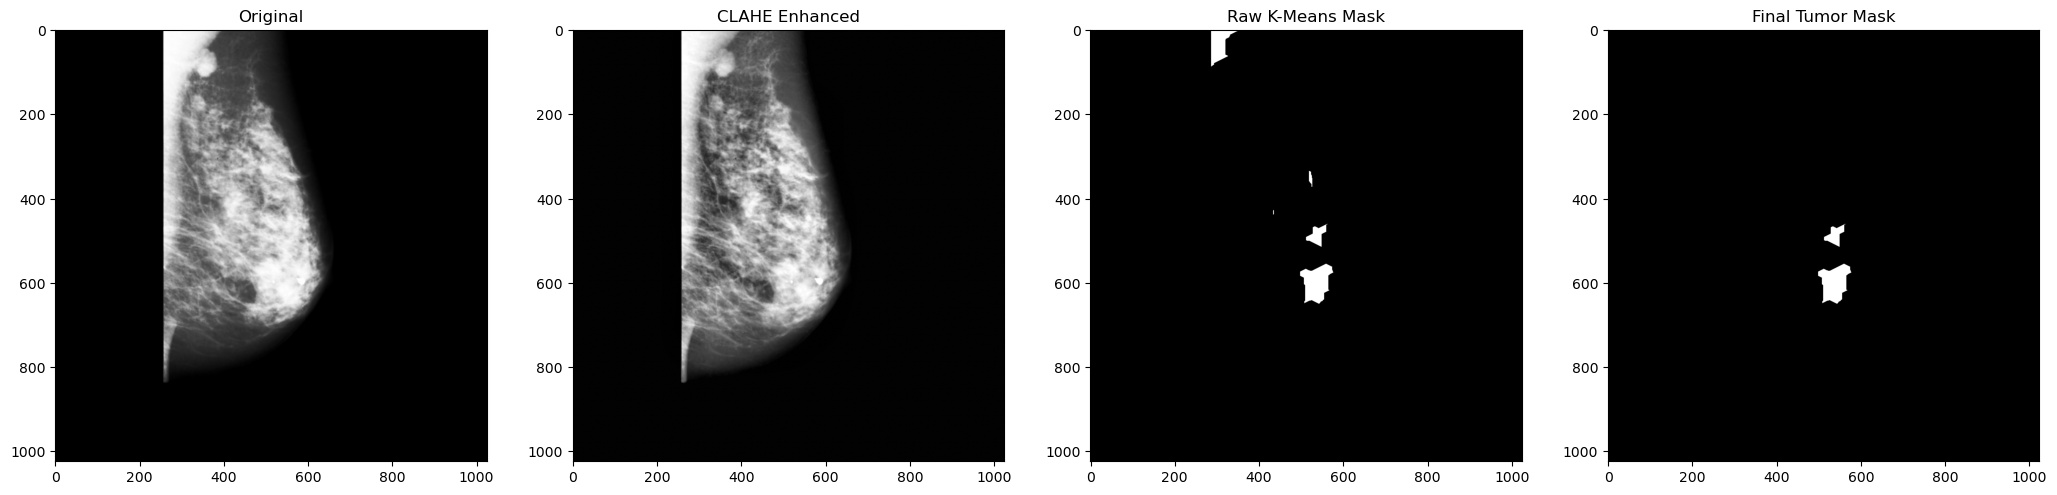

In [56]:
import cv2
import numpy as np

# =====================================================
# 1. CLAHE ENHANCEMENT
# =====================================================
# ClipLimit=4.0 is aggressive but good for dense masses
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(masked_img)

# =====================================================
# 2. K-MEANS CLUSTERING (INTENSITY SEPARATION)
# =====================================================
pixel_values = enhanced_img.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 3 # 1.Background, 2.Tissue, 3.Dense Mass + Muscle

_, labels, centers = cv2.kmeans(
    pixel_values, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS
)

centers = np.uint8(centers)
segmented = centers[labels.flatten()]
segmented = segmented.reshape(masked_img.shape)

# =====================================================
# 3. EXTRACT BRIGHTEST CLUSTER (Raw Mask)
# =====================================================
# This mask likely contains BOTH the tumor and the muscle
bright_cluster_idx = np.argmax(centers)
candidate_mask = (segmented == centers[bright_cluster_idx]).astype(np.uint8) * 255

# =====================================================
# 4. MORPHOLOGICAL CLEANUP
# =====================================================
kernel_clean = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
candidate_mask = cv2.morphologyEx(candidate_mask, cv2.MORPH_OPEN, kernel_clean)
candidate_mask = cv2.morphologyEx(candidate_mask, cv2.MORPH_CLOSE, kernel_clean)
# Reduced erosion to preserve tumor shape better
candidate_mask = cv2.erode(candidate_mask, kernel_clean, iterations=15)

# =====================================================
# 5. LOCATION FILTERING (The "What to do" part)
# =====================================================
# We need to distinguish the TUMOR from the MUSCLE
contours, _ = cv2.findContours(candidate_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

final_tumor_mask = np.zeros_like(candidate_mask)
height, width = candidate_mask.shape

for cnt in contours:
    area = cv2.contourArea(cnt)
    
    # 1. Filter small noise
    if area < 500: 
        continue

    # 2. Filter by Position and Shape
    x, y, w, h = cv2.boundingRect(cnt)
    cy = y + h // 2  # Center Y of the blob
    cx = x + w // 2  # Center X of the blob
    
    # Calculate aspect ratio and compactness
    aspect_ratio = float(w) / h if h > 0 else 0
    extent = area / (w * h) if (w * h) > 0 else 0
    
    # Filter criteria:
    # - Remove very top regions (likely muscle/chest wall)
    # - Keep regions in middle to lower regions
    # - Prefer more compact regions (higher extent)
    y_ratio = cy / height
    
    # Keep regions that are:
    # 1. Not in the top 25% (likely muscle)
    # 2. Have reasonable compactness (extent > 0.2)
    if y_ratio > 0.25 and extent > 0.2:
        cv2.drawContours(final_tumor_mask, [cnt], -1, 255, -1)

# =====================================================
# VISUALIZATION
# =====================================================
show_images(
    [masked_img, enhanced_img, candidate_mask, final_tumor_mask],
    ["Original", "CLAHE Enhanced", "Raw K-Means Mask", "Final Tumor Mask"]
)

Success: Tumor detected!
Detected centroid (x, y): (536.5, 601.4)
Area: 4631 pixels
Eccentricity: 0.708, Solidity: 0.808
Tumor score: 5.84

Other candidates:
  1. Centroid: (537.7, 488.5), Score: 5.71, Area: 1290


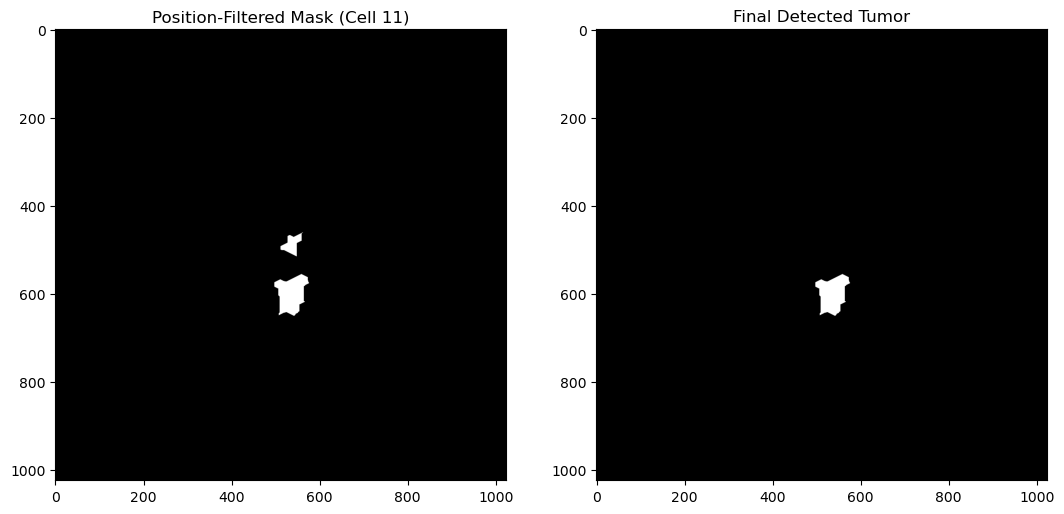

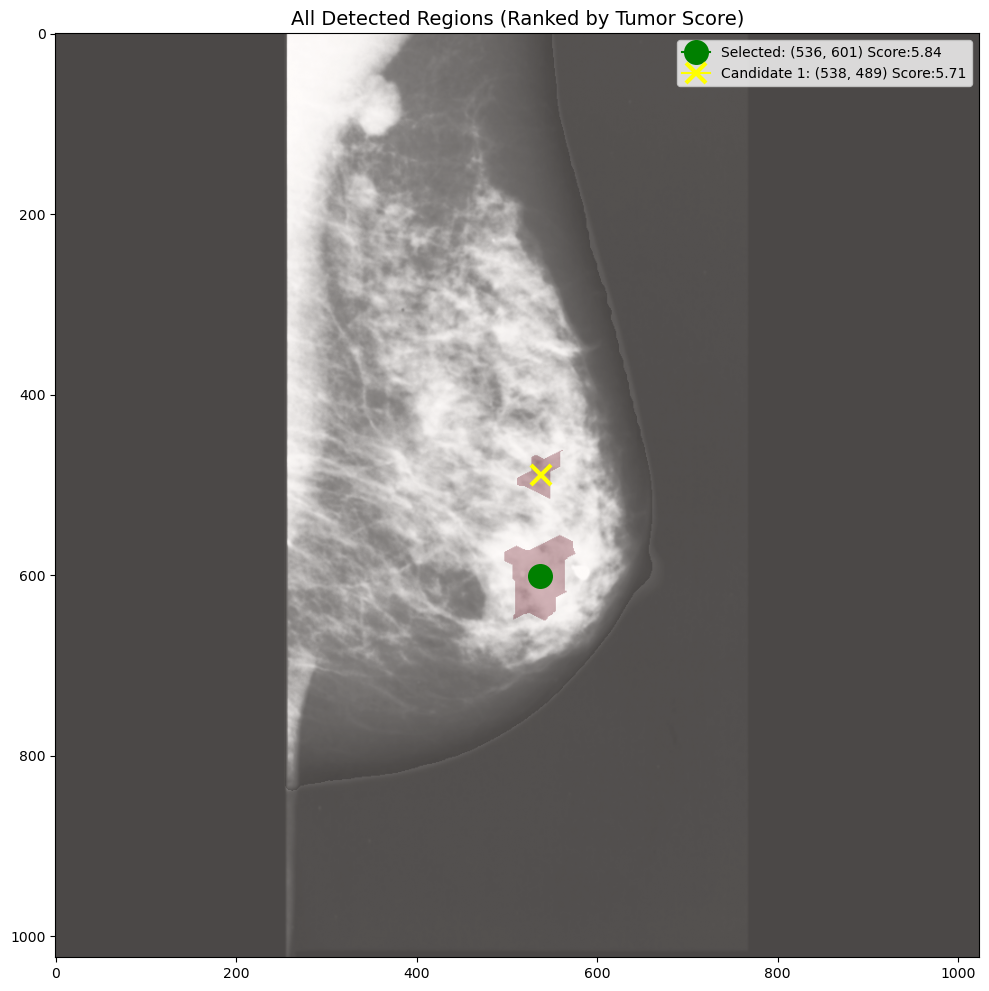

In [57]:
from skimage.measure import label, regionprops

# --- AUTOMATIC TUMOR DETECTION USING MULTIPLE HEURISTICS ---

# 1. Label all connected blobs
# Use final_tumor_mask from Cell 11 which already has position filtering applied
label_img = label(final_tumor_mask)
regions = regionprops(label_img, intensity_image=enhanced_img)

# Define a margin (in pixels). 
# Any blob within this distance from the edge will be ignored.
border_margin = 10 
height, width = final_tumor_mask.shape

valid_regions = []

for region in regions:
    # Get the bounding box of the blob
    min_row, min_col, max_row, max_col = region.bbox
    
    # CHECK: Is the blob fully inside the safe zone?
    if (min_row > border_margin and min_col > border_margin and 
        max_row < (height - border_margin) and max_col < (width - border_margin)):
        
        # Calculate tumor-specific features for scoring
        area = region.area
        region_y, region_x = region.centroid  # (row, col) = (y, x)
        
        # Heuristic 1: Size - tumors are typically medium-sized (not too small, not too large)
        # Typical tumor area: 1000-10000 pixels (adjust based on image resolution)
        size_score = 1.0
        if area < 500:
            size_score = 0.3  # Too small, likely noise
        elif area > 20000:
            size_score = 0.5  # Too large, likely muscle or artifact
        elif 1000 <= area <= 8000:
            size_score = 1.5  # Ideal size range
        
        # Heuristic 2: Compactness/Circularity - tumors are often more compact
        # Use eccentricity (0=circle, 1=line) - tumors are less eccentric
        eccentricity = region.eccentricity
        compactness_score = 1.0 - (eccentricity * 0.5)  # Prefer less eccentric (more circular)
        
        # Heuristic 3: Solidity - tumors are often more solid (less holes)
        solidity = region.solidity
        solidity_score = solidity  # Higher is better
        
        # Heuristic 4: Position - tumors are typically in middle regions, not at extreme edges
        # Prefer regions in middle 60% of image (avoid top 20% and bottom 20%)
        y_ratio = region_y / height
        position_score = 1.0
        if y_ratio < 0.2 or y_ratio > 0.8:
            position_score = 0.5  # Too close to top/bottom edge
        elif 0.3 <= y_ratio <= 0.7:
            position_score = 1.3  # Good middle region
        
        # Heuristic 5: Intensity - tumors often have higher average intensity
        # Get mean intensity of the region
        mean_intensity = region.mean_intensity
        # Normalize intensity score (assuming 0-255 range)
        intensity_score = mean_intensity / 255.0
        
        # Combined score (weighted combination)
        total_score = (size_score * 1.5 + 
                      compactness_score * 1.2 + 
                      solidity_score * 1.0 + 
                      position_score * 1.0 + 
                      intensity_score * 0.8)
        
        valid_regions.append((region, total_score, region_x, region_y, area, eccentricity, solidity))

# 2. Select the region with highest tumor score
if valid_regions:
    # Sort by total score (highest first)
    valid_regions.sort(key=lambda x: x[1], reverse=True)
    
    # Get the best scoring region
    selected_region, score, reg_x, reg_y, area, ecc, sol = valid_regions[0]
    
    # Create the final mask
    final_mask = np.zeros_like(final_tumor_mask)
    for r, c in selected_region.coords:
        final_mask[r, c] = 255
        
    print(f"Success: Tumor detected!")
    print(f"Detected centroid (x, y): ({reg_x:.1f}, {reg_y:.1f})")
    print(f"Area: {area:.0f} pixels")
    print(f"Eccentricity: {ecc:.3f}, Solidity: {sol:.3f}")
    print(f"Tumor score: {score:.2f}")
    
    # Also print info about other candidates
    if len(valid_regions) > 1:
        print(f"\nOther candidates:")
        for i, (reg, scr, rx, ry, ar, e, s) in enumerate(valid_regions[1:4], 1):  # Show top 3 others
            print(f"  {i}. Centroid: ({rx:.1f}, {ry:.1f}), Score: {scr:.2f}, Area: {ar:.0f}")
    
else:
    print("Warning: All detected blobs were too close to the border or no blobs found.")
    # Fallback: return empty mask
    final_mask = np.zeros_like(final_tumor_mask)

# Visualization
show_images(
    [final_tumor_mask, final_mask],
    ["Position-Filtered Mask (Cell 11)", "Final Detected Tumor"]
)

# Additional diagnostic: Show all detected regions with centroids
if valid_regions:
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img_eq, cmap='gray')
    ax.imshow(final_tumor_mask, alpha=0.3, cmap='Reds')
    
    # Plot all valid regions
    for i, (reg, scr, rx, ry, ar, e, s) in enumerate(valid_regions):
        color = 'green' if i == 0 else 'yellow'
        marker = 'o' if i == 0 else 'x'
        label_text = f"Selected: ({rx:.0f}, {ry:.0f}) Score:{scr:.2f}" if i == 0 else f"Candidate {i}: ({rx:.0f}, {ry:.0f}) Score:{scr:.2f}"
        ax.plot(rx, ry, color=color, marker=marker, markersize=15, markeredgewidth=3, label=label_text)
    
    ax.legend(fontsize=10, loc='upper right')
    ax.set_title('All Detected Regions (Ranked by Tumor Score)', fontsize=14)
    plt.show()

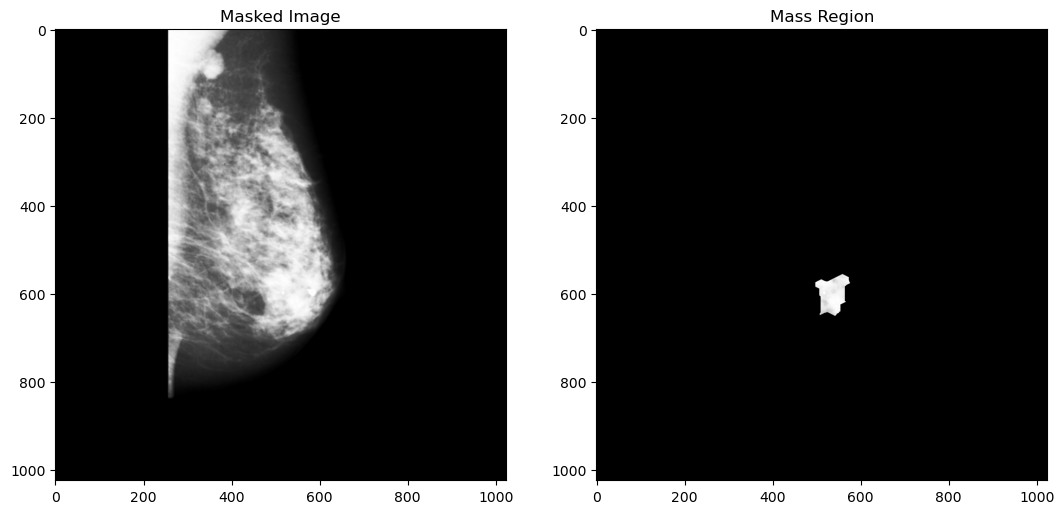

In [58]:
mass_region = cv2.bitwise_and(masked_img, masked_img, mask=final_mask)
show_images([masked_img, mass_region], ['Masked Image', 'Mass Region'])

In [59]:
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def extract_features(mass_mask, original_img):
    # Label connected components in the mass mask
    label_img = label(mass_mask)
    regions = regionprops(label_img, intensity_image=original_img)

    if not regions:
        print("No mass region found for feature extraction.")
        return None

    # Assuming the largest region is the mass
    largest_region = max(regions, key=lambda r: r.area)
    
    features = {}
    
    # --- Shape Features ---
    features['Area'] = largest_region.area
    features['Centroid'] = largest_region.centroid
    features['Perimeter'] = largest_region.perimeter
    features['Eccentricity'] = largest_region.eccentricity
    features['Solidity'] = largest_region.solidity
    features['Extent'] = largest_region.extent
    features['MajorAxisLength'] = largest_region.major_axis_length
    features['MinorAxisLength'] = largest_region.minor_axis_length

    # --- Texture Features using GLCM ---
    # We use the intensity image specific to the region (bounding box content)
    mass_region = largest_region.intensity_image
    
    # Normalize to 0-255 uint8 for GLCM
    if mass_region.max() > 0:
        mass_region = (mass_region * (255.0 / mass_region.max())).astype(np.uint8)
    else:
        mass_region = mass_region.astype(np.uint8)

    # Calculate GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix(mass_region, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    features['Contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['Dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
    features['Homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    features['Energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['Correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    features['ASM'] = graycoprops(glcm, 'ASM')[0, 0]

    return pd.DataFrame([features])

# Usage
# Ensure 'final_mask' and 'img_eq' are defined from previous steps
features_df = extract_features(final_mask, img_eq)

if features_df is not None:
    print(features_df)
    # Optional: Save to CSV
    # features_df.to_csv("mass_features.csv", index=False)

     Area                                Centroid   Perimeter  Eccentricity  \
0  4631.0  (601.4271215720147, 536.4651263226085)  325.001046      0.708452   

   Solidity    Extent  MajorAxisLength  MinorAxisLength     Contrast  \
0  0.808202  0.617055         96.46322        68.079826  1526.391903   

   Dissimilarity  Homogeneity    Energy  Correlation       ASM  
0       7.262348     0.708641  0.368002     0.943014  0.135426  


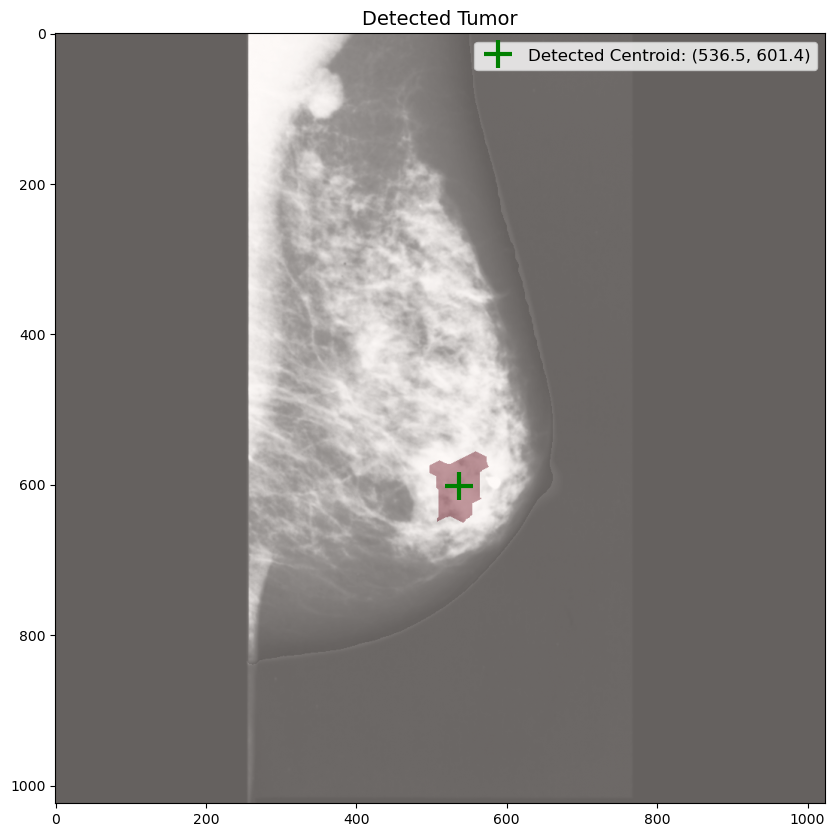

Detected tumor centroid (x, y): (536.5, 601.4)


In [60]:
# Visualize detected tumor
import matplotlib.pyplot as plt

# Get the detected centroid (from regionprops, it's in row, col format = y, x)
detected_centroid = features_df['Centroid'].iloc[0]  # (row, col) = (y, x)
detected_y, detected_x = detected_centroid[0], detected_centroid[1]

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_eq, cmap='gray')
ax.imshow(final_mask, alpha=0.4, cmap='Reds')
ax.plot(detected_x, detected_y, 'g+', markersize=20, markeredgewidth=3, label=f'Detected Centroid: ({detected_x:.1f}, {detected_y:.1f})')
ax.legend(fontsize=12)
ax.set_title('Detected Tumor', fontsize=14)
plt.show()

print(f"Detected tumor centroid (x, y): ({detected_x:.1f}, {detected_y:.1f})")


✓ Ground truth loaded for evaluation: Center=(356.0, 945.0), Radius=72.0
  (Ground truth will NOT be used during optimization)

Starting CSO optimization...
Optimizing based on detection quality metrics (NOT ground truth)
This may take a few minutes...

[NOTE] Optimization does NOT use ground truth.
    Optimizing based on detection quality metrics only.

Iteration 10/15, Best Fitness: 9.9963

OPTIMIZATION COMPLETE

Optimized Parameters:
  breast_thresh: 48.045
  clahe_clip: 1.085
  k_means_k: 5
  erosion_iter: 15.463
  y_ratio_thresh: 0.244
  extent_thresh: 0.221
  border_margin: 69.927
  size_weight: 1.902
  compact_weight: 1.224
  solidity_weight: 1.500
  position_weight: 1.310
  intensity_weight: 0.885

Best Fitness: 7.6151

Testing optimized parameters...
Detected centroid with optimized params: (539.7, 592.3)
Confidence: 7.65

📊 Evaluation (ground truth comparison):
   Distance error: 397.7 pixels
   Ground truth: (356.0, 945.0)
   Detected: (539.7, 592.3)
   Error normalized by 

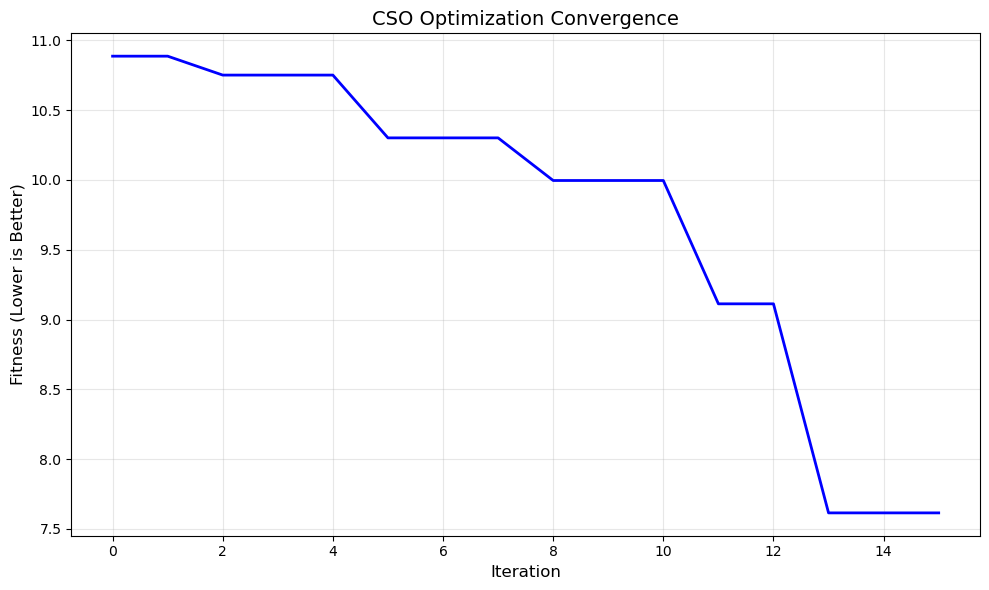

In [61]:
# =====================================================
# CSO OPTIMIZATION FOR TUMOR DETECTION PARAMETERS
# =====================================================
# This cell optimizes detection parameters using Cuckoo Search Optimization
# 
# IMPORTANT: Optimization does NOT use ground truth!
# It optimizes based on detection quality metrics:
# - Detection confidence/score
# - Number of candidates (prefer 1-3)
# - Shape quality (compactness, solidity)
# - Size appropriateness
# - Position within breast region

from cso_detection_optimizer import CSODetectionOptimizer
import pandas as pd

# Load ground truth data ONLY for evaluation (NOT for optimization)
ground_truth_for_eval = None
try:
    df = pd.read_csv('train_dataset.csv')
    # Find ground truth for current image
    image_basename = image_name.replace('.pgm', '')
    gt_row = df[df['REF'] == image_basename]
    if not gt_row.empty and pd.notna(gt_row.iloc[0]['X']):
        gt_x = float(gt_row.iloc[0]['X'])
        gt_y = float(gt_row.iloc[0]['Y'])
        gt_radius = float(gt_row.iloc[0]['RADIUS'])
        ground_truth_for_eval = (gt_x, gt_y, gt_radius)
        print(f"✓ Ground truth loaded for evaluation: Center=({gt_x}, {gt_y}), Radius={gt_radius}")
        print("  (Ground truth will NOT be used during optimization)\n")
    else:
        ground_truth_for_eval = None
        print("No ground truth available (optimization will proceed without it)\n")
except Exception as e:
    ground_truth_for_eval = None
    print(f"Could not load ground truth: {e}")
    print("(Optimization will proceed without it)\n")

# Initialize CSO optimizer
optimizer = CSODetectionOptimizer(n_nests=15, max_iterations=15, pa=0.25)

print("Starting CSO optimization...")
print("Optimizing based on detection quality metrics (NOT ground truth)")
print("This may take a few minutes...\n")

# Run optimization (ground truth NOT passed - optimization is unsupervised)
optimized_params = optimizer.optimize(img_blur)

print("\n" + "="*50)
print("OPTIMIZATION COMPLETE")
print("="*50)
print("\nOptimized Parameters:")
for key, value in optimized_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.3f}")
    else:
        print(f"  {key}: {value}")
print(f"\nBest Fitness: {optimizer.best_fitness:.4f}")

# Test optimized parameters
print("\nTesting optimized parameters...")
detected, confidence = optimizer._detect_tumor_with_params(img_blur, optimized_params)
if detected:
    det_x, det_y = detected
    print(f"Detected centroid with optimized params: ({det_x:.1f}, {det_y:.1f})")
    print(f"Confidence: {confidence:.2f}")
    
    # Evaluate against ground truth (if available) - FOR EVALUATION ONLY
    if ground_truth_for_eval:
        gt_x, gt_y, gt_radius = ground_truth_for_eval
        error = np.sqrt((det_x - gt_x)**2 + (det_y - gt_y)**2)
        print(f"\n📊 Evaluation (ground truth comparison):")
        print(f"   Distance error: {error:.1f} pixels")
        print(f"   Ground truth: ({gt_x}, {gt_y})")
        print(f"   Detected: ({det_x:.1f}, {det_y:.1f})")
        print(f"   Error normalized by radius: {error/max(gt_radius, 1.0):.2f}")
else:
    print("No tumor detected with optimized parameters")

# Plot fitness convergence
if len(optimizer.fitness_history) > 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(optimizer.fitness_history, 'b-', linewidth=2)
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Fitness (Lower is Better)', fontsize=12)
    ax.set_title('CSO Optimization Convergence', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [62]:
# =====================================================
# APPLY OPTIMIZED PARAMETERS TO DETECTION PIPELINE
# =====================================================
# Use the optimized parameters from CSO for better detection

# Note: Run Cell 16 first to get optimized_params
# If optimized_params is not available, use default values

if 'optimized_params' in locals() and optimized_params:
    print("Using CSO-optimized parameters...")
    params = optimized_params
else:
    print("Using default parameters (run Cell 16 for optimization)...")
    params = {
        'breast_thresh': 30,
        'clahe_clip': 2.0,
        'k_means_k': 3,
        'erosion_iter': 10,
        'y_ratio_thresh': 0.25,
        'extent_thresh': 0.2,
        'border_margin': 50,
        'size_weight': 1.5,
        'compact_weight': 1.2,
        'solidity_weight': 1.0,
        'position_weight': 1.0,
        'intensity_weight': 0.8
    }

# Apply optimized parameters to detection
breast_thresh = int(params['breast_thresh'])
clahe_clip = params['clahe_clip']
k_means_k = int(params['k_means_k'])
erosion_iter = int(params['erosion_iter'])
y_ratio_thresh = params['y_ratio_thresh']
extent_thresh = params['extent_thresh']
border_margin = int(params['border_margin'])
size_weight = params['size_weight']
compact_weight = params['compact_weight']
solidity_weight = params['solidity_weight']
position_weight = params['position_weight']
intensity_weight = params['intensity_weight']

print(f"\nApplied Parameters:")
print(f"  Breast threshold: {breast_thresh}")
print(f"  CLAHE clipLimit: {clahe_clip:.2f}")
print(f"  K-means K: {k_means_k}")
print(f"  Erosion iterations: {erosion_iter}")
print(f"  Y-ratio threshold: {y_ratio_thresh:.2f}")
print(f"  Extent threshold: {extent_thresh:.2f}")
print(f"  Border margin: {border_margin}")

# Now re-run the detection with optimized parameters
# (You can copy the detection code from previous cells and use these parameters)


Using CSO-optimized parameters...

Applied Parameters:
  Breast threshold: 48
  CLAHE clipLimit: 1.08
  K-means K: 5
  Erosion iterations: 15
  Y-ratio threshold: 0.24
  Extent threshold: 0.22
  Border margin: 69


Using optimized parameters:
  Breast threshold: 48
  CLAHE clipLimit: 1.08
  K-means K: 5
  Erosion iterations: 15
  Y-ratio threshold: 0.24
  Extent threshold: 0.22


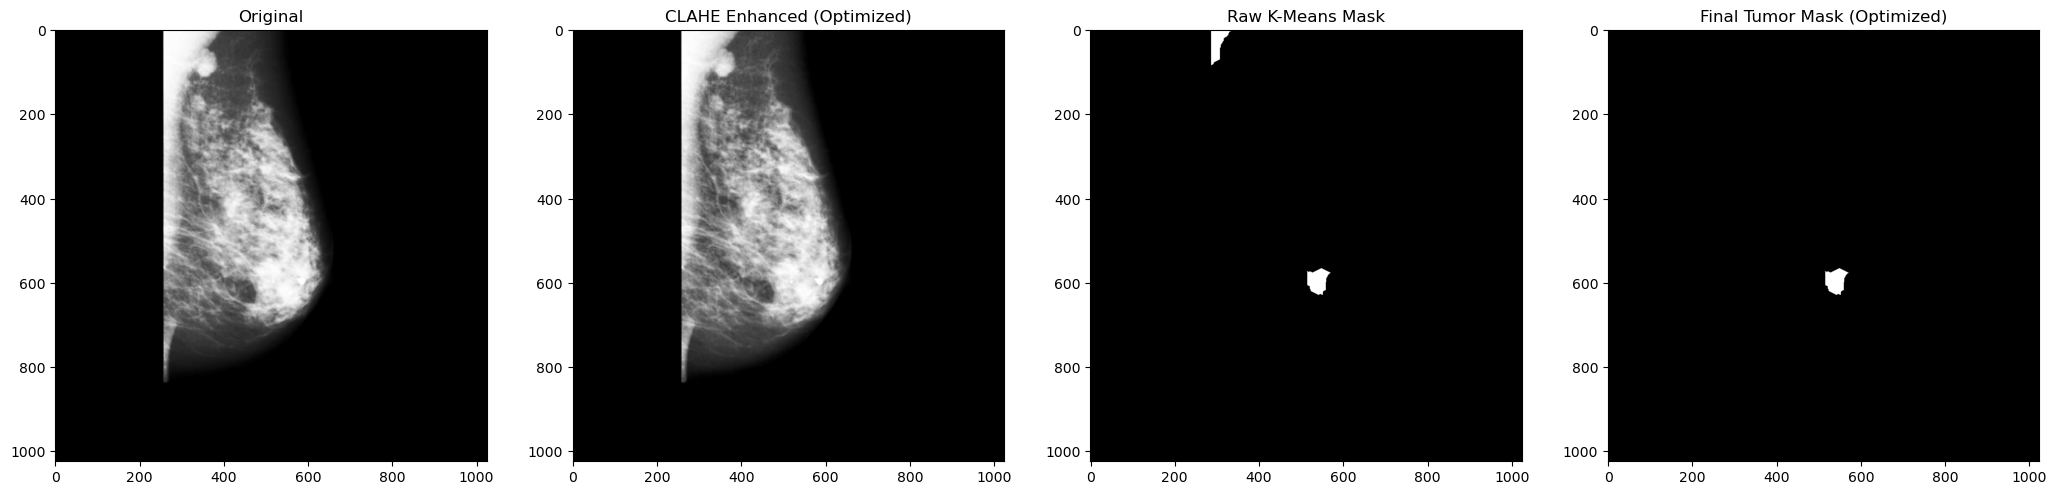

In [63]:
# =====================================================
# DETECTION WITH OPTIMIZED PARAMETERS (Cell 11 optimized version)
# =====================================================
# This cell re-runs the detection pipeline using CSO-optimized parameters

# Check if optimized parameters are available
if 'optimized_params' not in locals() or not optimized_params:
    print("ERROR: Run Cell 16 first to get optimized_params!")
    print("Using default parameters instead...")
    optimized_params = {
        'breast_thresh': 30, 'clahe_clip': 2.0, 'k_means_k': 3, 'erosion_iter': 10,
        'y_ratio_thresh': 0.25, 'extent_thresh': 0.2, 'border_margin': 50,
        'size_weight': 1.5, 'compact_weight': 1.2, 'solidity_weight': 1.0,
        'position_weight': 1.0, 'intensity_weight': 0.8
    }

import cv2
import numpy as np

# Extract optimized parameters
breast_thresh_opt = int(optimized_params['breast_thresh'])
clahe_clip_opt = optimized_params['clahe_clip']
k_means_k_opt = int(optimized_params['k_means_k'])
erosion_iter_opt = int(optimized_params['erosion_iter'])
y_ratio_thresh_opt = optimized_params['y_ratio_thresh']
extent_thresh_opt = optimized_params['extent_thresh']

print(f"Using optimized parameters:")
print(f"  Breast threshold: {breast_thresh_opt}")
print(f"  CLAHE clipLimit: {clahe_clip_opt:.2f}")
print(f"  K-means K: {k_means_k_opt}")
print(f"  Erosion iterations: {erosion_iter_opt}")
print(f"  Y-ratio threshold: {y_ratio_thresh_opt:.2f}")
print(f"  Extent threshold: {extent_thresh_opt:.2f}")

# =====================================================
# 1. CLAHE ENHANCEMENT (with optimized clipLimit)
# =====================================================
clahe = cv2.createCLAHE(clipLimit=clahe_clip_opt, tileGridSize=(8, 8))
enhanced_img_opt = clahe.apply(masked_img)

# =====================================================
# 2. K-MEANS CLUSTERING (with optimized K)
# =====================================================
pixel_values = enhanced_img_opt.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

_, labels, centers = cv2.kmeans(
    pixel_values, k_means_k_opt, None, criteria, 10, cv2.KMEANS_PP_CENTERS
)

centers = np.uint8(centers)
segmented = centers[labels.flatten()]
segmented = segmented.reshape(masked_img.shape)

# =====================================================
# 3. EXTRACT BRIGHTEST CLUSTER
# =====================================================
bright_cluster_idx = np.argmax(centers)
candidate_mask_opt = (segmented == centers[bright_cluster_idx]).astype(np.uint8) * 255

# =====================================================
# 4. MORPHOLOGICAL CLEANUP (with optimized iterations)
# =====================================================
kernel_clean = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
candidate_mask_opt = cv2.morphologyEx(candidate_mask_opt, cv2.MORPH_OPEN, kernel_clean)
candidate_mask_opt = cv2.morphologyEx(candidate_mask_opt, cv2.MORPH_CLOSE, kernel_clean)
candidate_mask_opt = cv2.erode(candidate_mask_opt, kernel_clean, iterations=erosion_iter_opt)

# =====================================================
# 5. LOCATION FILTERING (with optimized thresholds)
# =====================================================
contours, _ = cv2.findContours(candidate_mask_opt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

final_tumor_mask_opt = np.zeros_like(candidate_mask_opt)
height, width = candidate_mask_opt.shape

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 500: 
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    cy = y + h // 2
    extent = area / (w * h) if (w * h) > 0 else 0
    y_ratio = cy / height
    
    # Use optimized thresholds
    if y_ratio > y_ratio_thresh_opt and extent > extent_thresh_opt:
        cv2.drawContours(final_tumor_mask_opt, [cnt], -1, 255, -1)

# =====================================================
# VISUALIZATION
# =====================================================
show_images(
    [masked_img, enhanced_img_opt, candidate_mask_opt, final_tumor_mask_opt],
    ["Original", "CLAHE Enhanced (Optimized)", "Raw K-Means Mask", "Final Tumor Mask (Optimized)"]
)


Using optimized scoring weights:
  Size weight: 1.90
  Compactness weight: 1.22
  Solidity weight: 1.50
  Position weight: 1.31
  Intensity weight: 0.88
  Border margin: 69

✅ Success: Tumor detected with optimized parameters!
Detected centroid (x, y): (539.3, 596.7)
Area: 2340 pixels
Eccentricity: 0.589, Solidity: 0.874
Tumor score: 7.55


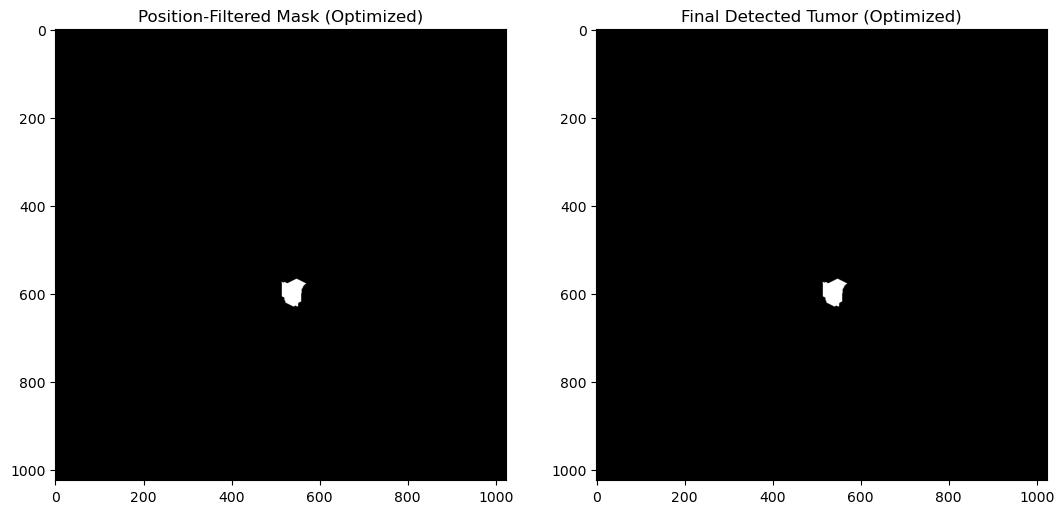

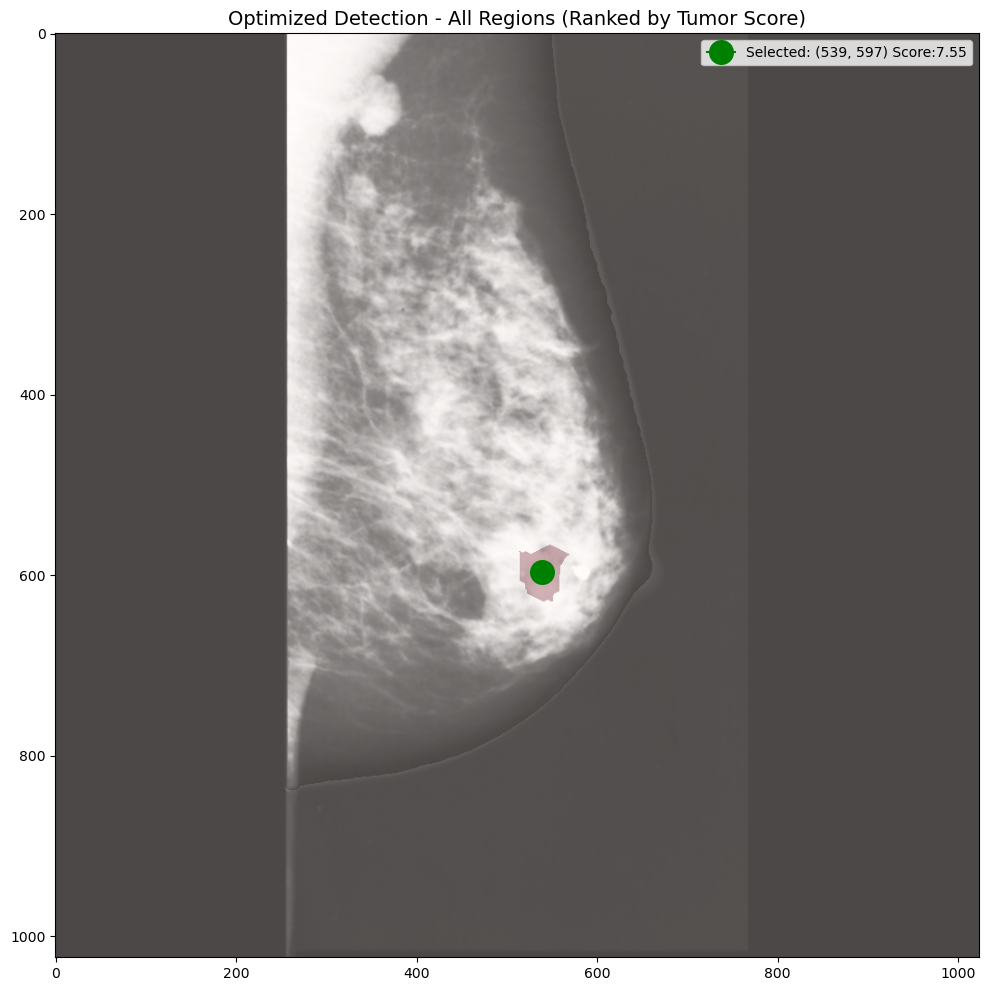

In [64]:
# =====================================================
# AUTOMATIC TUMOR DETECTION WITH OPTIMIZED SCORING (Cell 12 optimized version)
# =====================================================

from skimage.measure import label, regionprops

# Check if optimized parameters are available
if 'optimized_params' not in locals() or not optimized_params:
    print("ERROR: Run Cell 16 first!")
    optimized_params = {
        'border_margin': 50, 'size_weight': 1.5, 'compact_weight': 1.2,
        'solidity_weight': 1.0, 'position_weight': 1.0, 'intensity_weight': 0.8
    }

# Extract optimized scoring weights
border_margin_opt = int(optimized_params['border_margin'])
size_weight_opt = optimized_params['size_weight']
compact_weight_opt = optimized_params['compact_weight']
solidity_weight_opt = optimized_params['solidity_weight']
position_weight_opt = optimized_params['position_weight']
intensity_weight_opt = optimized_params['intensity_weight']

print(f"Using optimized scoring weights:")
print(f"  Size weight: {size_weight_opt:.2f}")
print(f"  Compactness weight: {compact_weight_opt:.2f}")
print(f"  Solidity weight: {solidity_weight_opt:.2f}")
print(f"  Position weight: {position_weight_opt:.2f}")
print(f"  Intensity weight: {intensity_weight_opt:.2f}")
print(f"  Border margin: {border_margin_opt}")

# 1. Label all connected blobs
label_img_opt = label(final_tumor_mask_opt)
regions_opt = regionprops(label_img_opt, intensity_image=enhanced_img_opt)

height, width = final_tumor_mask_opt.shape
valid_regions_opt = []

for region in regions_opt:
    min_row, min_col, max_row, max_col = region.bbox
    
    # CHECK: Is the blob fully inside the safe zone?
    if (min_row > border_margin_opt and min_col > border_margin_opt and 
        max_row < (height - border_margin_opt) and max_col < (width - border_margin_opt)):
        
        area = region.area
        region_y, region_x = region.centroid
        eccentricity = region.eccentricity
        solidity = region.solidity
        mean_intensity = region.mean_intensity
        y_ratio = region_y / height
        
        # Scoring with optimized weights
        size_score = 1.0
        if 1000 <= area <= 8000:
            size_score = 1.5
        elif area < 500:
            size_score = 0.3
        elif area > 20000:
            size_score = 0.5
        
        compactness_score = 1.0 - (eccentricity * 0.5)
        solidity_score = solidity
        
        position_score = 1.0
        if 0.3 <= y_ratio <= 0.7:
            position_score = 1.3
        elif y_ratio < 0.2 or y_ratio > 0.8:
            position_score = 0.5
        
        intensity_score = mean_intensity / 255.0
        
        # Use optimized weights
        total_score = (size_score * size_weight_opt + 
                      compactness_score * compact_weight_opt + 
                      solidity_score * solidity_weight_opt + 
                      position_score * position_weight_opt + 
                      intensity_score * intensity_weight_opt)
        
        valid_regions_opt.append((region, total_score, region_x, region_y, area, eccentricity, solidity))

# 2. Select the region with highest tumor score
if valid_regions_opt:
    valid_regions_opt.sort(key=lambda x: x[1], reverse=True)
    
    selected_region_opt, score_opt, reg_x_opt, reg_y_opt, area_opt, ecc_opt, sol_opt = valid_regions_opt[0]
    
    final_mask_opt = np.zeros_like(final_tumor_mask_opt)
    for r, c in selected_region_opt.coords:
        final_mask_opt[r, c] = 255
        
    print(f"\n✅ Success: Tumor detected with optimized parameters!")
    print(f"Detected centroid (x, y): ({reg_x_opt:.1f}, {reg_y_opt:.1f})")
    print(f"Area: {area_opt:.0f} pixels")
    print(f"Eccentricity: {ecc_opt:.3f}, Solidity: {sol_opt:.3f}")
    print(f"Tumor score: {score_opt:.2f}")
    
    if len(valid_regions_opt) > 1:
        print(f"\nOther candidates:")
        for i, (reg, scr, rx, ry, ar, e, s) in enumerate(valid_regions_opt[1:4], 1):
            print(f"  {i}. Centroid: ({rx:.1f}, {ry:.1f}), Score: {scr:.2f}, Area: {ar:.0f}")
    
else:
    print("⚠️ Warning: No tumor detected with optimized parameters.")
    final_mask_opt = np.zeros_like(final_tumor_mask_opt)

# Visualization
show_images(
    [final_tumor_mask_opt, final_mask_opt],
    ["Position-Filtered Mask (Optimized)", "Final Detected Tumor (Optimized)"]
)

# Additional diagnostic visualization
if valid_regions_opt:
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img_eq, cmap='gray')
    ax.imshow(final_tumor_mask_opt, alpha=0.3, cmap='Reds')
    
    for i, (reg, scr, rx, ry, ar, e, s) in enumerate(valid_regions_opt):
        color = 'green' if i == 0 else 'yellow'
        marker = 'o' if i == 0 else 'x'
        label_text = f"Selected: ({rx:.0f}, {ry:.0f}) Score:{scr:.2f}" if i == 0 else f"Candidate {i}: ({rx:.0f}, {ry:.0f}) Score:{scr:.2f}"
        ax.plot(rx, ry, color=color, marker=marker, markersize=15, markeredgewidth=3, label=label_text)
    
    ax.legend(fontsize=10, loc='upper right')
    ax.set_title('Optimized Detection - All Regions (Ranked by Tumor Score)', fontsize=14)
    plt.show()


✓ Ground truth: Center=(356.0, 945.0), Radius=72.0

📊 Original Detection:
   Detected centroid: (536.5, 601.4)
   Detected radius: 55.4 pixels
   IoU (circle vs circle): 0.0000

📊 Optimized Detection:
   Detected centroid: (539.3, 596.7)
   Detected radius: 35.7 pixels
   IoU (circle vs circle): 0.0000

CENTROID-IN-RADIUS CHECK
Original Detection:
  Centroid: (536.5, 601.4)
  Distance from GT center: 388.1 pixels
  GT radius: 72.0 pixels
  Inside GT circle? ❌ NO

Optimized Detection:
  Centroid: (539.3, 596.7)
  Distance from GT center: 393.6 pixels
  GT radius: 72.0 pixels
  Inside GT circle? ❌ NO

COMPARISON RESULTS
⚖️  Both detections have the same IoU: 0.0000

IoU Summary:
  Original IoU:   0.0000
  Optimized IoU:  0.0000
  Best (IoU): Tie

Centroid-in-Radius Summary:
  Original:  ❌ NO (distance: 388.1 px)
  Optimized: ❌ NO (distance: 393.6 px)

🏆 WINNER (Centroid Check): ORIGINAL detection!
   Both are outside, but original is closer to circle
   (Original: 388.1px, Optimized: 393

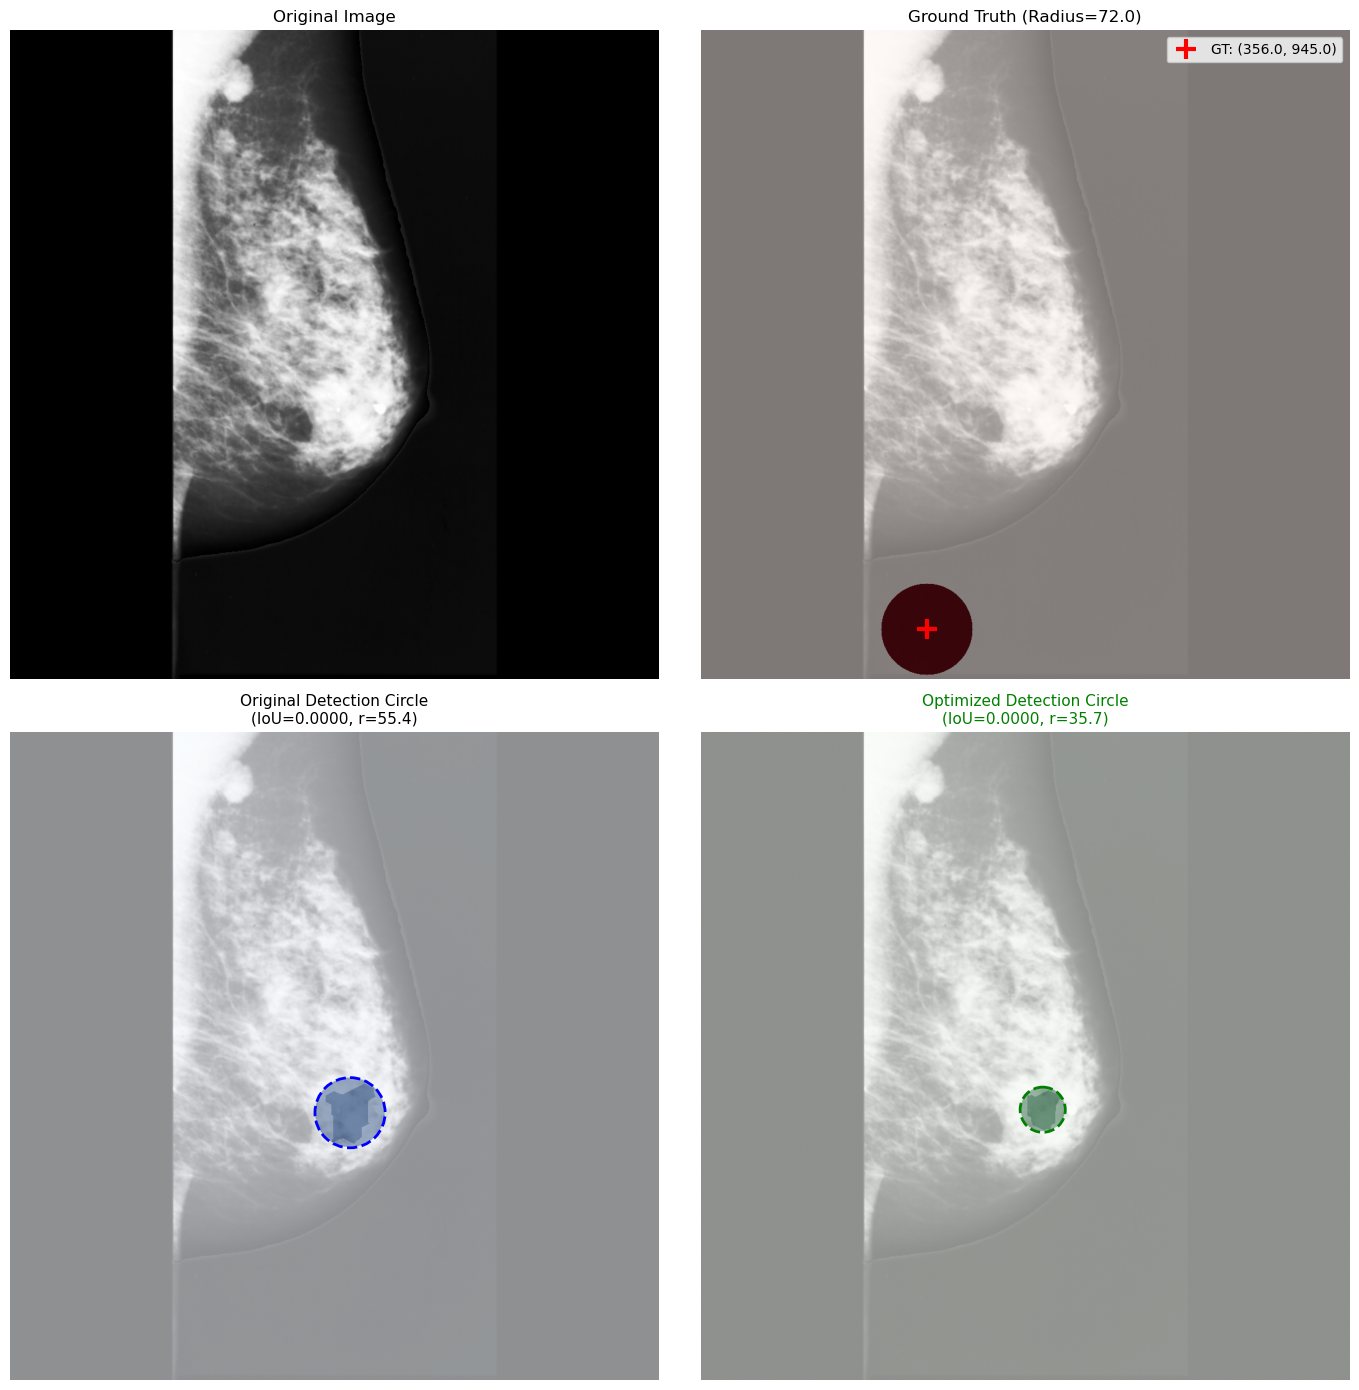

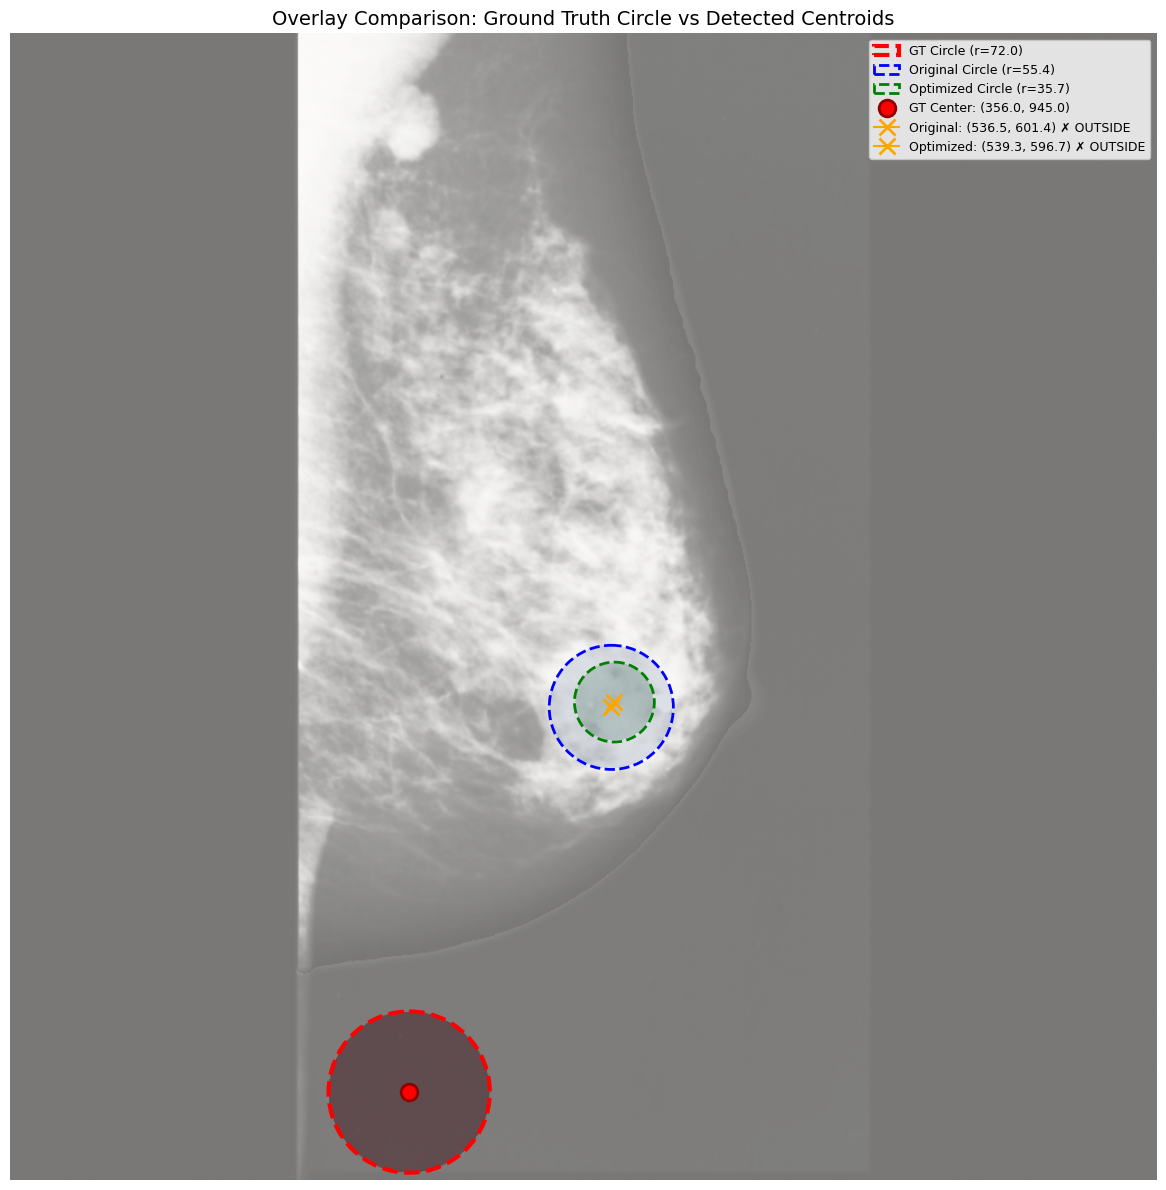


FINAL SUMMARY TABLE
Metric                         Original           Optimized         
------------------------------------------------------------------
IoU (circle vs circle)         0.0000             0.0000            
Detected radius                55.4               35.7              
Centroid in GT circle          ❌ NO              
Centroid in GT circle                             ❌ NO              
Distance from GT center        388.1              393.6             


In [65]:
# =====================================================
# IoU COMPARISON: Original vs Optimized Detection
# =====================================================
# Compare IoU between ground truth and both detection methods

from evaluate_detection import calculate_iou, create_ground_truth_mask
import matplotlib.pyplot as plt

# Check if we have both detections
if 'final_mask' not in locals():
    print("⚠️ Warning: Original detection (final_mask) not found. Run Cell 12 first.")
    final_mask = None

if 'final_mask_opt' not in locals():
    print("⚠️ Warning: Optimized detection (final_mask_opt) not found. Run Cell 19 first.")
    final_mask_opt = None

# Load ground truth
ground_truth_available = False
if 'ground_truth_for_eval' in locals() and ground_truth_for_eval:
    gt_x, gt_y, gt_radius = ground_truth_for_eval
    ground_truth_available = True
    print(f"✓ Ground truth: Center=({gt_x}, {gt_y}), Radius={gt_radius}")
else:
    # Try to load from CSV
    try:
        df = pd.read_csv('train_dataset.csv')
        image_basename = image_name.replace('.pgm', '')
        gt_row = df[df['REF'] == image_basename]
        if not gt_row.empty and pd.notna(gt_row.iloc[0]['X']):
            gt_x = float(gt_row.iloc[0]['X'])
            gt_y = float(gt_row.iloc[0]['Y'])
            gt_radius = float(gt_row.iloc[0]['RADIUS'])
            ground_truth_available = True
            print(f"✓ Ground truth loaded: Center=({gt_x}, {gt_y}), Radius={gt_radius}")
        else:
            print("❌ No ground truth available for this image")
    except Exception as e:
        print(f"❌ Could not load ground truth: {e}")

if ground_truth_available:
    # Get image shape
    if 'img_eq' in locals():
        img_shape = img_eq.shape
    elif 'img_blur' in locals():
        img_shape = img_blur.shape
    else:
        img_shape = (1024, 1024)  # Default
    
    # Create ground truth mask (circular)
    gt_mask = create_ground_truth_mask(img_shape, (gt_x, gt_y), gt_radius)
    
    # =====================================================
    # CREATE CIRCULAR MASKS FOR DETECTED MASSES
    # =====================================================
    # Function to create circular mask from detected mass
    def create_detected_circle_mask(mask, centroid_x, centroid_y, img_shape):
        """
        Create a circular mask that surrounds the detected mass.
        Radius = farthest point in the mass from the centroid.
        """
        # Find all points in the mask
        y_coords, x_coords = np.where(mask > 0)
        
        if len(x_coords) == 0:
            return None, 0.0
        
        # Calculate distance from centroid to each point
        distances = np.sqrt((x_coords - centroid_x)**2 + (y_coords - centroid_y)**2)
        
        # Find maximum distance (radius)
        detected_radius = np.max(distances)
        
        # Create circular mask
        circle_mask = np.zeros(img_shape, dtype=np.uint8)
        cv2.circle(circle_mask, (int(centroid_x), int(centroid_y)), int(detected_radius), 255, -1)
        
        return circle_mask, detected_radius
    
    # Calculate IoU for original detection (using circular mask)
    iou_original = None
    detected_radius_original = None
    detected_circle_original = None
    
    if final_mask is not None:
        # Get centroid from features_df
        if 'features_df' in locals():
            try:
                orig_centroid = features_df['Centroid'].iloc[0]
                orig_y, orig_x = orig_centroid[0], orig_centroid[1]
                
                # Create circular mask for detected mass
                detected_circle_original, detected_radius_original = create_detected_circle_mask(
                    final_mask, orig_x, orig_y, img_shape
                )
                
                if detected_circle_original is not None:
                    # Calculate IoU between circles
                    iou_original = calculate_iou(detected_circle_original, gt_mask)
                    print(f"\n📊 Original Detection:")
                    print(f"   Detected centroid: ({orig_x:.1f}, {orig_y:.1f})")
                    print(f"   Detected radius: {detected_radius_original:.1f} pixels")
                    print(f"   IoU (circle vs circle): {iou_original:.4f}")
                else:
                    print("\n❌ Cannot create circular mask for original detection")
            except Exception as e:
                print(f"\n❌ Error processing original detection: {e}")
        else:
            print("\n❌ Cannot get centroid for original detection (features_df not found)")
    else:
        print("\n❌ Cannot calculate IoU for original detection (mask not found)")
    
    # Calculate IoU for optimized detection (using circular mask)
    iou_optimized = None
    detected_radius_optimized = None
    detected_circle_optimized = None
    
    if final_mask_opt is not None:
        # Get centroid from optimized detection
        if 'reg_x_opt' in locals() and 'reg_y_opt' in locals():
            # Create circular mask for detected mass
            detected_circle_optimized, detected_radius_optimized = create_detected_circle_mask(
                final_mask_opt, reg_x_opt, reg_y_opt, img_shape
            )
            
            if detected_circle_optimized is not None:
                # Calculate IoU between circles
                iou_optimized = calculate_iou(detected_circle_optimized, gt_mask)
                print(f"\n📊 Optimized Detection:")
                print(f"   Detected centroid: ({reg_x_opt:.1f}, {reg_y_opt:.1f})")
                print(f"   Detected radius: {detected_radius_optimized:.1f} pixels")
                print(f"   IoU (circle vs circle): {iou_optimized:.4f}")
            else:
                print("❌ Cannot create circular mask for optimized detection")
        else:
            print("❌ Cannot get centroid for optimized detection")
    else:
        print("❌ Cannot calculate IoU for optimized detection (mask not found)")
    
    # =====================================================
    # CENTROID-IN-RADIUS CHECK (Boolean)
    # =====================================================
    print("\n" + "="*60)
    print("CENTROID-IN-RADIUS CHECK")
    print("="*60)
    
    # Function to check if centroid is inside ground truth circle
    def is_centroid_inside_radius(det_x, det_y, gt_x, gt_y, gt_radius):
        """Check if detected centroid is inside ground truth circle."""
        distance = np.sqrt((det_x - gt_x)**2 + (det_y - gt_y)**2)
        return distance <= gt_radius, distance
    
    # Check original detection
    inside_original = None
    dist_original = None
    if final_mask is not None and 'features_df' in locals():
        try:
            orig_centroid = features_df['Centroid'].iloc[0]
            orig_y, orig_x = orig_centroid[0], orig_centroid[1]
            inside_original, dist_original = is_centroid_inside_radius(orig_x, orig_y, gt_x, gt_y, gt_radius)
            status_orig = "✅ YES" if inside_original else "❌ NO"
            print(f"Original Detection:")
            print(f"  Centroid: ({orig_x:.1f}, {orig_y:.1f})")
            print(f"  Distance from GT center: {dist_original:.1f} pixels")
            print(f"  GT radius: {gt_radius:.1f} pixels")
            print(f"  Inside GT circle? {status_orig}")
        except Exception as e:
            print(f"Original Detection: Could not get centroid ({e})")
    
    # Check optimized detection
    inside_optimized = None
    dist_optimized = None
    if final_mask_opt is not None and 'reg_x_opt' in locals() and 'reg_y_opt' in locals():
        inside_optimized, dist_optimized = is_centroid_inside_radius(reg_x_opt, reg_y_opt, gt_x, gt_y, gt_radius)
        status_opt = "✅ YES" if inside_optimized else "❌ NO"
        print(f"\nOptimized Detection:")
        print(f"  Centroid: ({reg_x_opt:.1f}, {reg_y_opt:.1f})")
        print(f"  Distance from GT center: {dist_optimized:.1f} pixels")
        print(f"  GT radius: {gt_radius:.1f} pixels")
        print(f"  Inside GT circle? {status_opt}")
    
    # Compare and determine winner
    print("\n" + "="*60)
    print("COMPARISON RESULTS")
    print("="*60)
    
    # IoU comparison
    if iou_original is not None and iou_optimized is not None:
        if iou_optimized > iou_original:
            improvement = ((iou_optimized - iou_original) / iou_original) * 100
            print(f"✅ OPTIMIZED detection is BETTER (IoU)!")
            print(f"   Improvement: {improvement:.2f}%")
            print(f"   IoU difference: {iou_optimized - iou_original:.4f}")
            winner_iou = "Optimized"
        elif iou_original > iou_optimized:
            degradation = ((iou_original - iou_optimized) / iou_optimized) * 100
            print(f"⚠️  ORIGINAL detection is better (IoU)")
            print(f"   Degradation: {degradation:.2f}%")
            print(f"   IoU difference: {iou_original - iou_optimized:.4f}")
            winner_iou = "Original"
        else:
            print(f"⚖️  Both detections have the same IoU: {iou_original:.4f}")
            winner_iou = "Tie"
        
        print(f"\nIoU Summary:")
        print(f"  Original IoU:   {iou_original:.4f}")
        print(f"  Optimized IoU:  {iou_optimized:.4f}")
        print(f"  Best (IoU): {winner_iou}")
    
    # Centroid-in-radius comparison
    print(f"\nCentroid-in-Radius Summary:")
    if inside_original is not None:
        print(f"  Original:  {status_orig} (distance: {dist_original:.1f} px)")
    if inside_optimized is not None:
        print(f"  Optimized: {status_opt} (distance: {dist_optimized:.1f} px)")
    
    # Determine overall winner based on centroid check
    if inside_original is not None and inside_optimized is not None:
        if inside_optimized and not inside_original:
            print(f"\n🏆 WINNER (Centroid Check): OPTIMIZED detection!")
            print(f"   Optimized centroid is INSIDE ground truth circle")
            print(f"   Original centroid is OUTSIDE ground truth circle")
            winner_centroid = "Optimized"
        elif inside_original and not inside_optimized:
            print(f"\n🏆 WINNER (Centroid Check): ORIGINAL detection!")
            print(f"   Original centroid is INSIDE ground truth circle")
            print(f"   Optimized centroid is OUTSIDE ground truth circle")
            winner_centroid = "Original"
        elif inside_original and inside_optimized:
            # Both inside - compare distances
            if dist_optimized < dist_original:
                print(f"\n🏆 WINNER (Centroid Check): OPTIMIZED detection!")
                print(f"   Both are inside, but optimized is closer to center")
                print(f"   (Optimized: {dist_optimized:.1f}px, Original: {dist_original:.1f}px)")
                winner_centroid = "Optimized"
            elif dist_original < dist_optimized:
                print(f"\n🏆 WINNER (Centroid Check): ORIGINAL detection!")
                print(f"   Both are inside, but original is closer to center")
                print(f"   (Original: {dist_original:.1f}px, Optimized: {dist_optimized:.1f}px)")
                winner_centroid = "Original"
            else:
                print(f"\n⚖️  TIE (Centroid Check): Both are inside and equidistant")
                winner_centroid = "Tie"
        else:
            # Both outside - compare distances
            if dist_optimized < dist_original:
                print(f"\n🏆 WINNER (Centroid Check): OPTIMIZED detection!")
                print(f"   Both are outside, but optimized is closer to circle")
                print(f"   (Optimized: {dist_optimized:.1f}px, Original: {dist_original:.1f}px)")
                winner_centroid = "Optimized"
            elif dist_original < dist_optimized:
                print(f"\n🏆 WINNER (Centroid Check): ORIGINAL detection!")
                print(f"   Both are outside, but original is closer to circle")
                print(f"   (Original: {dist_original:.1f}px, Optimized: {dist_optimized:.1f}px)")
                winner_centroid = "Original"
            else:
                print(f"\n⚖️  TIE (Centroid Check): Both are outside and equidistant")
                winner_centroid = "Tie"
    elif inside_original is not None:
        print(f"\n🏆 Only original detection available")
        winner_centroid = "Original" if inside_original else "None"
    elif inside_optimized is not None:
        print(f"\n🏆 Only optimized detection available")
        winner_centroid = "Optimized" if inside_optimized else "None"
    elif iou_original is not None:
        print(f"Only original detection available: IoU = {iou_original:.4f}")
    elif iou_optimized is not None:
        print(f"Only optimized detection available: IoU = {iou_optimized:.4f}")
    
    # Visualization: Show all masks together
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    
    # Original image
    axes[0, 0].imshow(img_eq if 'img_eq' in locals() else img_blur, cmap='gray')
    axes[0, 0].set_title('Original Image', fontsize=12)
    axes[0, 0].axis('off')
    
    # Ground truth
    axes[0, 1].imshow(img_eq if 'img_eq' in locals() else img_blur, cmap='gray')
    axes[0, 1].imshow(gt_mask, alpha=0.5, cmap='Reds')
    axes[0, 1].plot(gt_x, gt_y, 'r+', markersize=15, markeredgewidth=3, label=f'GT: ({gt_x}, {gt_y})')
    axes[0, 1].set_title(f'Ground Truth (Radius={gt_radius})', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].axis('off')
    
    # Original detection (show circular mask)
    if final_mask is not None:
        axes[1, 0].imshow(img_eq if 'img_eq' in locals() else img_blur, cmap='gray')
        # Show actual mask in light blue
        axes[1, 0].imshow(final_mask, alpha=0.3, cmap='Blues')
        # Show circular mask overlay
        if detected_circle_original is not None:
            axes[1, 0].imshow(detected_circle_original, alpha=0.4, cmap='Blues')
            # Draw circle outline
            if 'features_df' in locals():
                try:
                    orig_centroid = features_df['Centroid'].iloc[0]
                    orig_y, orig_x = orig_centroid[0], orig_centroid[1]
                    circle_det = plt.Circle((orig_x, orig_y), detected_radius_original, 
                                          color='blue', fill=False, linewidth=2, linestyle='--')
                    axes[1, 0].add_patch(circle_det)
                except:
                    pass
        if iou_original is not None:
            axes[1, 0].set_title(f'Original Detection Circle\n(IoU={iou_original:.4f}, r={detected_radius_original:.1f})', fontsize=11)
        else:
            axes[1, 0].set_title('Original Detection', fontsize=12)
    else:
        axes[1, 0].text(0.5, 0.5, 'Original detection\nnot available', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Original Detection', fontsize=12)
    axes[1, 0].axis('off')
    
    # Optimized detection (show circular mask)
    if final_mask_opt is not None:
        axes[1, 1].imshow(img_eq if 'img_eq' in locals() else img_blur, cmap='gray')
        # Show actual mask in light green
        axes[1, 1].imshow(final_mask_opt, alpha=0.3, cmap='Greens')
        # Show circular mask overlay
        if detected_circle_optimized is not None:
            axes[1, 1].imshow(detected_circle_optimized, alpha=0.4, cmap='Greens')
            # Draw circle outline
            if 'reg_x_opt' in locals() and 'reg_y_opt' in locals():
                circle_det_opt = plt.Circle((reg_x_opt, reg_y_opt), detected_radius_optimized, 
                                           color='green', fill=False, linewidth=2, linestyle='--')
                axes[1, 1].add_patch(circle_det_opt)
        if iou_optimized is not None:
            title_color = 'green' if (iou_optimized > iou_original if iou_original else True) else 'red'
            axes[1, 1].set_title(f'Optimized Detection Circle\n(IoU={iou_optimized:.4f}, r={detected_radius_optimized:.1f})', 
                               fontsize=11, color=title_color)
        else:
            axes[1, 1].set_title('Optimized Detection', fontsize=12)
    else:
        axes[1, 1].text(0.5, 0.5, 'Optimized detection\nnot available', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Optimized Detection', fontsize=12)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Overlay comparison with centroid-in-radius visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img_eq if 'img_eq' in locals() else img_blur, cmap='gray')
    
    # Draw ground truth circle
    circle_gt = plt.Circle((gt_x, gt_y), gt_radius, color='red', fill=False, 
                          linewidth=3, linestyle='--', label=f'GT Circle (r={gt_radius:.1f})')
    ax.add_patch(circle_gt)
    
    # Draw detected circles
    if detected_circle_original is not None and 'features_df' in locals():
        try:
            orig_centroid = features_df['Centroid'].iloc[0]
            orig_y, orig_x = orig_centroid[0], orig_centroid[1]
            circle_orig = plt.Circle((orig_x, orig_y), detected_radius_original, 
                                   color='blue', fill=False, linewidth=2, linestyle='--',
                                   label=f'Original Circle (r={detected_radius_original:.1f})')
            ax.add_patch(circle_orig)
        except:
            pass
    
    if detected_circle_optimized is not None and 'reg_x_opt' in locals() and 'reg_y_opt' in locals():
        circle_opt = plt.Circle((reg_x_opt, reg_y_opt), detected_radius_optimized, 
                              color='green', fill=False, linewidth=2, linestyle='--',
                              label=f'Optimized Circle (r={detected_radius_optimized:.1f})')
        ax.add_patch(circle_opt)
    
    # Overlay circular masks with different colors
    if detected_circle_original is not None:
        ax.imshow(detected_circle_original, alpha=0.2, cmap='Blues', label='Original Circle Mask')
    if detected_circle_optimized is not None:
        ax.imshow(detected_circle_optimized, alpha=0.2, cmap='Greens', label='Optimized Circle Mask')
    ax.imshow(gt_mask, alpha=0.2, cmap='Reds', label='Ground Truth Circle Mask')
    
    # Plot centroids with status indicators
    ax.plot(gt_x, gt_y, 'ro', markersize=12, markeredgewidth=2, 
           markerfacecolor='red', markeredgecolor='darkred', label=f'GT Center: ({gt_x}, {gt_y})')
    
    if final_mask is not None and 'features_df' in locals():
        try:
            orig_centroid = features_df['Centroid'].iloc[0]
            orig_y, orig_x = orig_centroid[0], orig_centroid[1]
            marker_color = 'green' if inside_original else 'orange'
            marker_style = 'o' if inside_original else 'x'
            marker_size = 15 if inside_original else 12
            status_text = "✓ INSIDE" if inside_original else "✗ OUTSIDE"
            ax.plot(orig_x, orig_y, marker=marker_style, color=marker_color, 
                   markersize=marker_size, markeredgewidth=2,
                   label=f'Original: ({orig_x:.1f}, {orig_y:.1f}) {status_text}')
        except:
            pass
    
    if final_mask_opt is not None and 'reg_x_opt' in locals() and 'reg_y_opt' in locals():
        marker_color = 'green' if inside_optimized else 'orange'
        marker_style = 'o' if inside_optimized else 'x'
        marker_size = 15 if inside_optimized else 12
        status_text = "✓ INSIDE" if inside_optimized else "✗ OUTSIDE"
        ax.plot(reg_x_opt, reg_y_opt, marker=marker_style, color=marker_color,
               markersize=marker_size, markeredgewidth=2,
               label=f'Optimized: ({reg_x_opt:.1f}, {reg_y_opt:.1f}) {status_text}')
    
    ax.set_title('Overlay Comparison: Ground Truth Circle vs Detected Centroids', fontsize=14)
    ax.legend(fontsize=9, loc='upper right')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "="*60)
    print("FINAL SUMMARY TABLE")
    print("="*60)
    print(f"{'Metric':<30} {'Original':<18} {'Optimized':<18}")
    print("-" * 66)
    if iou_original is not None and iou_optimized is not None:
        print(f"{'IoU (circle vs circle)':<30} {iou_original:<18.4f} {iou_optimized:<18.4f}")
    if detected_radius_original is not None:
        print(f"{'Detected radius':<30} {detected_radius_original:<18.1f}", end="")
        if detected_radius_optimized is not None:
            print(f" {detected_radius_optimized:<18.1f}")
        else:
            print()
    elif detected_radius_optimized is not None:
        print(f"{'Detected radius':<30} {'':<18} {detected_radius_optimized:<18.1f}")
    if inside_original is not None:
        orig_status = "✅ YES" if inside_original else "❌ NO"
        print(f"{'Centroid in GT circle':<30} {orig_status:<18}")
    if inside_optimized is not None:
        opt_status = "✅ YES" if inside_optimized else "❌ NO"
        print(f"{'Centroid in GT circle':<30} {'':<18} {opt_status:<18}")
    if dist_original is not None:
        print(f"{'Distance from GT center':<30} {dist_original:<18.1f}", end="")
        if dist_optimized is not None:
            print(f" {dist_optimized:<18.1f}")
        else:
            print()
    elif dist_optimized is not None:
        print(f"{'Distance from GT center':<30} {'':<18} {dist_optimized:<18.1f}")
    print("="*60)
    
else:
    print("\n⚠️ Cannot perform IoU comparison without ground truth data.")
